In [1]:
import os, sys, random, warnings, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm.auto import tqdm, trange
from itertools import chain

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, Input, layers, callbacks, utils, optimizers

In [2]:
class config:
    im_width = 128
    im_height = 128
    im_chan = 1
    path_train = 'train/'
    path_test = 'test/'

# Data Exploration

In [3]:
! unzip -q ../input/tgs-salt-identification-challenge/train.zip -d train/
! unzip -q ../input/tgs-salt-identification-challenge/test.zip -d test/

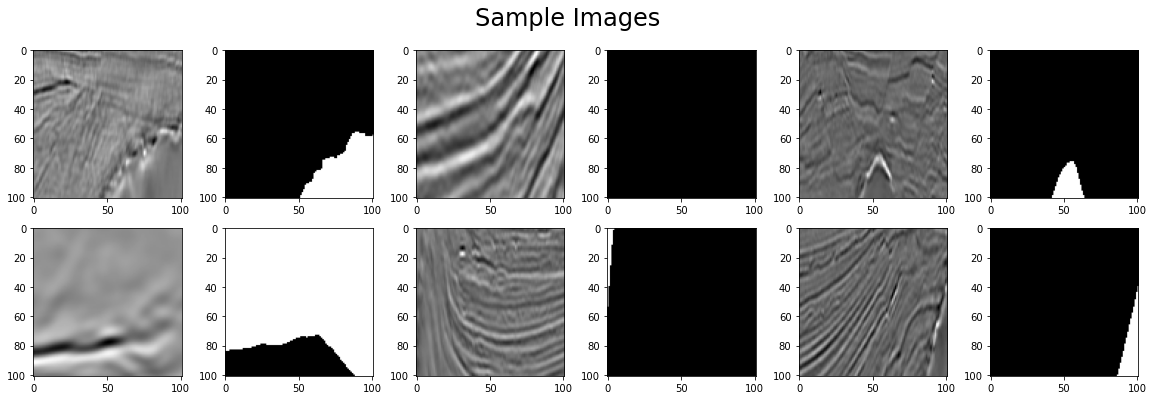

In [4]:
random.seed(19)
ids = random.choices(os.listdir('train/images'), k=6)
fig = plt.figure(figsize=(20,6))
for j, img_name in enumerate(ids):
    q = j+1
    
    img = load_img('train/images/' + img_name)
    img_mask = load_img('train/masks/' + img_name)
    
    plt.subplot(2, 6, q*2-1)
    plt.imshow(img)
    plt.subplot(2, 6, q*2)
    plt.imshow(img_mask)
fig.suptitle('Sample Images', fontsize=24);

In [5]:
train_ids = next(os.walk(config.path_train+"images"))[2]
test_ids = next(os.walk(config.path_test+"images"))[2]

In [6]:
X = np.zeros((len(train_ids), config.im_height, config.im_width, config.im_chan), dtype=np.uint8)
Y = np.zeros((len(train_ids), config.im_height, config.im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    x = img_to_array(load_img(config.path_train + '/images/' + id_, color_mode="grayscale"))
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X[n] = x
    mask = img_to_array(load_img(config.path_train + '/masks/' + id_, color_mode="grayscale"))
    Y[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

Getting and resizing train images and masks ... 



Done!
X shape: (4000, 128, 128, 1)
Y shape: (4000, 128, 128, 1)


# Augmentation and Cross Validation

In [7]:
X_train = X[:int(0.9*len(X))]
Y_train = Y[:int(0.9*len(X))]
X_eval  = X[int(0.9*len(X)):]
Y_eval  = Y[int(0.9*len(X)):]

X_train = np.append(X_train, [np.fliplr(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in Y], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.flipud(x) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=1) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=1) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=3) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=3) for x in Y], axis=0)

del X, Y

print('X train shape:', X_train.shape, 'X eval shape:', X_eval.shape)
print('Y train shape:', Y_train.shape, 'Y eval shape:', Y_eval.shape)

X train shape: (11600, 128, 128, 1) X eval shape: (400, 128, 128, 1)
Y train shape: (11600, 128, 128, 1) Y eval shape: (400, 128, 128, 1)


# Model Building

In [8]:
def BatchActivate(x):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = layers.Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [9]:
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    scaled = layers.Lambda(lambda x: x / 255) (input_layer)

    # 101 -> 50
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(scaled)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(DropoutRatio)(pool4)

    # Middle
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(DropoutRatio)(uconv4)
    
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])    
    uconv3 = layers.Dropout(DropoutRatio)(uconv3)
    
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
        
    uconv2 = layers.Dropout(DropoutRatio)(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    
    uconv1 = layers.Dropout(DropoutRatio)(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = layers.Dropout(DropoutRatio/2)(uconv1)
    #output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = layers.Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  layers.Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

input_layer = Input((config.im_height, config.im_width, config.im_chan))
output_layer = build_model(input_layer, 16)


model = models.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
_______________________________________________________________________________________

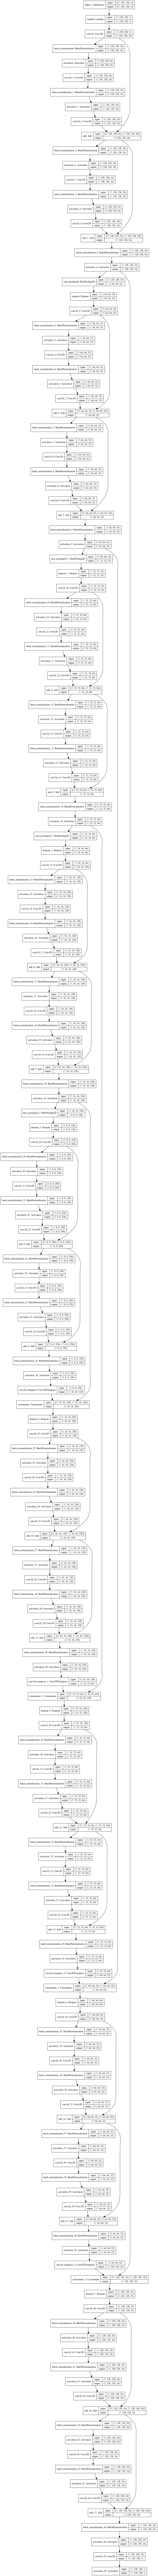

In [10]:
utils.plot_model(model, expand_nested=True, show_shapes=True)

In [11]:
es = callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)
rlp = callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-12, verbose=1)

results = model.fit(
    X_train, Y_train, validation_data=(X_eval, Y_eval), batch_size=8, epochs=300, callbacks=[es, rlp]
)

Epoch 1/300
1450/1450 [==============================] - 59s 41ms/step - loss: 0.3920 - acc: 0.8346 - val_loss: 0.3670 - val_acc: 0.8645
Epoch 2/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.3093 - acc: 0.8761 - val_loss: 0.2429 - val_acc: 0.9063
Epoch 3/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.2644 - acc: 0.8959 - val_loss: 0.3149 - val_acc: 0.8816
Epoch 4/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.2283 - acc: 0.9136 - val_loss: 0.1754 - val_acc: 0.9339
Epoch 5/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.2060 - acc: 0.9228 - val_loss: 0.4798 - val_acc: 0.7977
Epoch 6/300
1450/1450 [==============================] - 59s 40ms/step - loss: 0.1982 - acc: 0.9260 - val_loss: 0.1959 - val_acc: 0.9262
Epoch 7/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.1865 - acc: 0.9291 - val_loss: 0.2137 - val_acc: 0.9184
Epoch 8/300
1450/1450 [==================

Epoch 58/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.0616 - acc: 0.9761 - val_loss: 0.1122 - val_acc: 0.9560
Epoch 59/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.0615 - acc: 0.9762 - val_loss: 0.1109 - val_acc: 0.9561
Epoch 60/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.0623 - acc: 0.9765 - val_loss: 0.1111 - val_acc: 0.9563
Epoch 61/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.0615 - acc: 0.9762 - val_loss: 0.1109 - val_acc: 0.9562
Epoch 62/300
1449/1450 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9761
Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
1450/1450 [==============================] - 58s 40ms/step - loss: 0.0618 - acc: 0.9761 - val_loss: 0.1109 - val_acc: 0.9562
Epoch 63/300
1450/1450 [==============================] - 58s 40ms/step - loss: 0.0616 - acc: 0.9768 - val_loss: 0.1114 - val_acc: 0.9561
Epoch 64/

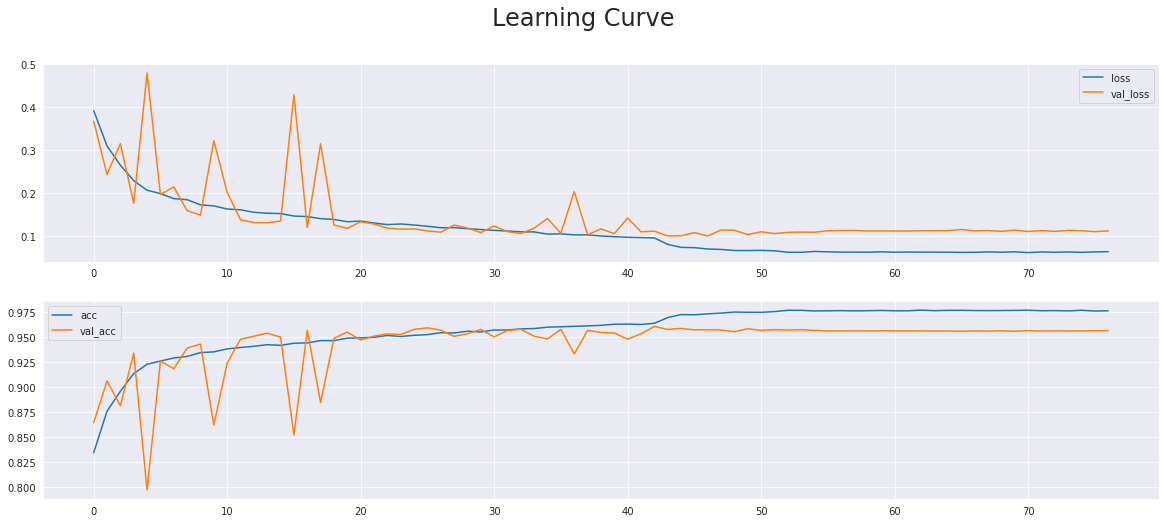

In [12]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
history = pd.DataFrame(results.history)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['acc', 'val_acc']].plot(ax=ax[1])
fig.suptitle('Learning Curve', fontsize=24);

# Scoring

In [13]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

13/13 [==============================] - 1s 39ms/step


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


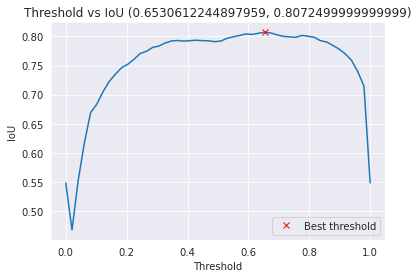

In [14]:
preds_eval = model.predict(X_eval, verbose=1)

thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(Y_eval, np.int32(preds_eval > threshold)) for threshold in tqdm(thresholds)])

threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend();

# Model Evaluation

In [15]:
# Get and resize test images
X_test = np.zeros((len(test_ids), config.im_height, config.im_width, config.im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    x = img_to_array(load_img(config.path_test + '/images/' + id_, color_mode="grayscale"))
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [16]:
preds_test = model.predict(X_test, verbose=1)
preds_test_upsampled = []
for i in trange(len(preds_test)):
    preds_test_upsampled.append(resize(
        np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]),  mode='constant', preserve_range=True
    ))

563/563 [==============================] - 19s 33ms/step


In [17]:
!rm -rf train
!rm -rf test

In [18]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {
    fn[:-4]:RLenc(np.round(preds_test_upsampled[i] > threshold_best)) 
    for i,fn in tqdm(enumerate(test_ids), total=len(test_ids))
}

In [19]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')